<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Intro to PyTorch

## Deliverable

For this lab, you will submit an ipython notebook via learningsuite.
This lab will be mostly boilerplate code, but you will be required to implement a few extras.

**NOTE: you almost certainly will not understand most of what's going on in this lab!
That's ok - the point is just to get you going with pytorch.
We'll be working on developing a deeper understanding of every part of this code
over the course of the next two weeks.**

A major goal of this lab is to help you become conversant in working through pytorch
tutorials and documentation.
So, you should feel free to google whatever you want and need!

This notebook will have three parts:

* Part 1: Your notebook should contain the boilerplate code. See below.

* Part 2: Your notebook should extend the boilerplate code by adding a testing loop.

* Part 3: Your notebook should extend the boilerplate code by adding a visualization of test/training performance over time.

The resulting image could, for example, look like this:
![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?cache=&w=900&h=608&tok=3092fe&media=cs501r_f2018:lab2.png)
See the assigned readings for pointers to documentation on pytorch.
___

### Grading standards:
Your notebook will be graded on the following:

* 50% Successfully followed lab video and typed in code
* 20% Modified code to include a test/train split
* 20% Modified code to include a visualization of train/test losses
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Description
Throughout this class, we will be using pytorch to implement our deep neural networks. 
Pytorch is a deep learning framework that handles the low-level details of 
GPU integration and automatic differentiation.

The goal of this lab is to help you become familiar with pytorch. 
The three parts of the lab are outlined above.

For part 1, you should watch the video below, and type in the code as it is explained to you.

A more detailed outline of Part 1 is below.

For part 2, you must add a validation (or testing) loop using the 
FashionMNIST dataset with train=False

For part 3, you must plot the loss values and demonstrate overfitting.

The easiest way to do this is to limit the size of your training dataset 
so that it only returns a single batch (ie len(dataloader) == batch_size, 
and train for multiple epochs. In the example graph above, 
I set my batch size to 42, and augmented my dataloader to produce only 42 
unique items by overwriting the len function to return 42. 
In my training loop, I performed a validation every epoch which basically corresponded 
to a validation every step.

In practice, you will normally compute your validation loss every n steps, 
rather than at the end of every epoch. This is because some epochs can take hours, 
or even days and you don’t often want to wait that long to see your results.

Testing your algorithm by using a single batch and training until overfitting 
is a great way of making sure that your model and optimizer are working the way they should!

___

### Part 0
Watch Tutorial Video

[https://youtu.be/0P-YctShbwc](https://youtu.be/0P-YctShbwc)

**TODO:**

**DONE:**
* Watch video
___

### Part 1
Your notebook should contain the boilerplate code. See below.

**TODO:**

**DONE:**

* Replicate boilerplate from the video
___

### Part 2
Your notebook should extend the boilerplate code by adding a testing loop.

**TODO:**

**DONE:**

* Add a testing (validation) loop

In [0]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from statistics import mean

assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type

# Write the boilerplate code from the video here

# Create a dataset class that extends the torch.utils.data Dataset class here
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root,
                                      train=train,
                                      transform=transforms.ToTensor(),
                                      download=True)
  def __getitem__(self, i):
    x, y = self.data[i]
    return x, y

  def __len__(self):
    return len(self.data)

# Extend the torch.Module class to create your own neural network
class LinearNetwork(nn.Module):
  def __init__(self, in_dim=784, out_dim=10):
    super(LinearNetwork, self).__init__()
    self.net = nn.Sequential(nn.Linear(in_dim, out_dim))
    
    self.net = nn.Sequential(nn.Linear(in_dim, out_dim))

  def forward(self, x):
    n, c, h, w = x.size()
    flattened = x.view(n, c * h * w)
    return self.net(flattened)

# Instantiate the train and validation sets
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
val_dataset = FashionMNISTProcessedDataset('/tmp/fasionmnist', train = False)

# Instantiate your data loaders
train_loader = DataLoader(train_dataset,
                          batch_size=40, #I know the TA code has this at 42 but 40 is a factor of 60,000...
                          pin_memory=True)

val_loader = DataLoader(val_dataset,
                        batch_size = 40,
                        pin_memory=True)

# Instantiate your model and loss and optimizer functions
x, y = train_dataset.data[0]
in_dim = x.flatten().size()[0]

out_dim = 10

model = LinearNetwork(in_dim, out_dim)
model = model.cuda()

objective = torch.nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=1e-4)

# Run your training / validation loops
train_losses = []
average_train_losses = []
val_losses = []
average_val_losses = []
previous_val_loss = 8.0
total_epochs = 25

for epoch in range(total_epochs):
  loop = tqdm(total=len(train_loader)+len(val_loader), position=0)
  train_losses.clear()
  val_losses.clear()

  for x, y_truth in train_loader:
    x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
    optimizer.zero_grad()

    y_hat = model(x)
    loss = objective(y_hat, y_truth)

    train_losses.append(loss.item())

    loop.set_description('training loss:{:.4f}'.format(loss.item()))
    loop.update(1)

    loss.backward()
    optimizer.step()

  for x, y_truth in val_loader:
    x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
    
    y_hat = model(x)
    
    loss = objective(y_hat, y_truth)

    val_losses.append(loss.item())

    loop.set_description('validation loss:{:.4f}'.format(loss.item()))
    loop.update(1)

  average_train_losses.append(mean(train_losses))
  average_val_losses.append(mean(val_losses))

  loop.close()


validation loss:0.8431: 100%|██████████| 1750/1750 [00:10<00:00, 176.35it/s]



___

### Part 3
Your notebook should extend the boilerplate code by adding a visualization of test/training
performance over time. Use matplotlib.pyplot

**TODO:**

**DONE:**
* Add a visualization of test/train performance (i.e. loss) over time.


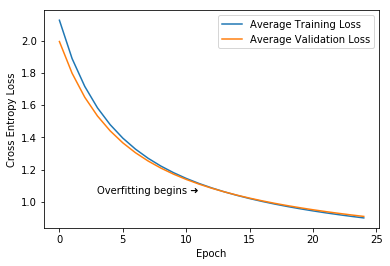

In [17]:
plt.plot(average_train_losses)#, label='Average Training Loss')
plt.plot(average_val_losses)#, label='Average Validation Loss' )
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.legend(['Average Training Loss', 'Average Validation Loss'])
plt.annotate(xy=[3,1.05], s='Overfitting begins ➜')
plt.show()